In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
df = pd.read_csv('Travel.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 14  Passport

# Data Cleaning

## Handling Missing Values

In [7]:
df.isnull().sum()

CustomerID                    0
ProdTaken                     0
Age                         226
TypeofContact                25
CityTier                      0
DurationOfPitch             251
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            45
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               140
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     66
Designation                   0
MonthlyIncome               233
dtype: int64

In [8]:
df['Gender'].value_counts()

Gender
Male       2916
Female     1817
Fe Male     155
Name: count, dtype: int64

In [9]:
df['Gender'] = df['Gender'].replace('Fe Male','Female')
df['MaritalStatus'] = df['MaritalStatus'].replace('Unmarried','Single')

In [10]:
df.isna().sum()

CustomerID                    0
ProdTaken                     0
Age                         226
TypeofContact                25
CityTier                      0
DurationOfPitch             251
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            45
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               140
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     66
Designation                   0
MonthlyIncome               233
dtype: int64

In [11]:
features_with_na = [features for features in df.columns if df[features].isnull().sum()>1]
for feature in features_with_na:
    print(feature, np.round(df[feature].isnull().mean()*100, 5),  ' % missing values')

Age 4.62357  % missing values
TypeofContact 0.51146  % missing values
DurationOfPitch 5.13502  % missing values
NumberOfFollowups 0.92062  % missing values
PreferredPropertyStar 0.53191  % missing values
NumberOfTrips 2.86416  % missing values
NumberOfChildrenVisiting 1.35025  % missing values
MonthlyIncome 4.76678  % missing values


In [12]:
df[features_with_na].select_dtypes(exclude='object').describe()

,Age,DurationOfPitch,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,NumberOfChildrenVisiting,MonthlyIncome
count,4662.000000,4637.000000,4843.000000,4862.000000,4748.000000,4822.000000,4655.000000
mean,37.622265,15.490835,3.708445,3.581037,3.236521,1.187267,23619.853491
std,9.316387,8.519643,1.002509,0.798009,1.849019,0.857861,5380.698361
min,18.000000,5.000000,1.000000,3.000000,1.000000,0.000000,1000.000000
25%,31.000000,9.000000,3.000000,3.000000,2.000000,1.000000,20346.000000
50%,36.000000,13.000000,4.000000,3.000000,3.000000,1.000000,22347.000000
75%,44.000000,20.000000,4.000000,4.000000,4.000000,2.000000,25571.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,3.000000,98678.000000


In [13]:
df.Age.fillna(df.Age.median(), inplace=True)
df.TypeofContact.fillna(df.TypeofContact.mode()[0], inplace=True)
df.DurationOfPitch.fillna(df.DurationOfPitch.median(), inplace=True)
df.NumberOfFollowups.fillna(df.NumberOfFollowups.mode()[0], inplace=True)
df.PreferredPropertyStar.fillna(df.PreferredPropertyStar.mode()[0], inplace=True)
df.NumberOfTrips.fillna(df.NumberOfTrips.median() , inplace=True)
df.NumberOfChildrenVisiting.fillna(df.NumberOfChildrenVisiting.mode()[0] , inplace=True)
df.MonthlyIncome.fillna(df.MonthlyIncome.median(), inplace=True)

In [14]:
df.drop('CustomerID', axis=1, inplace=True)

In [15]:
df['TotalVisiting'] = df['NumberOfPersonVisiting']  + df['NumberOfChildrenVisiting']
df.drop(['NumberOfPersonVisiting', 'NumberOfChildrenVisiting'], axis=1, inplace=True)

In [16]:
df.head()

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,Designation,MonthlyIncome,TotalVisiting
0,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3.0,Deluxe,3.0,Single,1.0,1,2,1,Manager,20993.0,3.0
1,0,49.0,Company Invited,1,14.0,Salaried,Male,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,Manager,20130.0,5.0
2,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,4.0,Basic,3.0,Single,7.0,1,3,0,Executive,17090.0,3.0
3,0,33.0,Company Invited,1,9.0,Salaried,Female,3.0,Basic,3.0,Divorced,2.0,1,5,1,Executive,17909.0,3.0
4,0,36.0,Self Enquiry,1,8.0,Small Business,Male,3.0,Basic,4.0,Divorced,1.0,0,5,1,Executive,18468.0,2.0


In [17]:
num_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
print('Number of numerical features: ', len(num_features))

Number of numerical features:  12


# Model Training    

In [18]:
from sklearn.model_selection import train_test_split
X = df.drop(['ProdTaken'], axis=1)
y = df['ProdTaken']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((3910, 17), (978, 17))

In [20]:
cat_features = X.select_dtypes(include='object').columns
num_features = X.select_dtypes(exclude='object').columns

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [21]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score, recall_score, f1_score, roc_auc_score

In [23]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_f1 = f1_score(y_train, y_train_pred)
    model_train_precision = precision_score(y_train, y_train_pred)
    model_train_recall = recall_score(y_train, y_train_pred)
    model_train_roc_auc = roc_auc_score(y_train, y_train_pred)
    
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred)
    model_test_precision = precision_score(y_test, y_test_pred)
    model_test_recall = recall_score(y_test, y_test_pred)
    model_test_roc_auc = roc_auc_score(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    
    print('Training Accuracy: ', model_train_accuracy)
    print('Training Precision: ', model_train_precision)
    print('Training Recall: ', model_train_recall)
    print('Training F1 Score: ', model_train_f1)
    print('Training ROC AUC Score: ', model_train_roc_auc)
    print('\n')
    
    print('Testing Accuracy: ', model_test_accuracy)
    print('Testing Precision: ', model_test_precision)
    print('Testing Recall: ', model_test_recall)
    print('Testing F1 Score: ', model_test_f1)
    print('Testing ROC AUC Score: ', model_test_roc_auc)
    print('\n')
    
    
    

Logistic Regression
Training Accuracy:  0.8460358056265984
Training Precision:  0.7015873015873015
Training Recall:  0.30315500685871055
Training F1 Score:  0.42337164750957856
Training ROC AUC Score:  0.6368022755136056


Testing Accuracy:  0.83640081799591
Testing Precision:  0.691358024691358
Testing Recall:  0.2931937172774869
Testing F1 Score:  0.4117647058823529
Testing ROC AUC Score:  0.630713758257549


Random Forest
Training Accuracy:  1.0
Training Precision:  1.0
Training Recall:  1.0
Training F1 Score:  1.0
Training ROC AUC Score:  1.0


Testing Accuracy:  0.9233128834355828
Testing Precision:  0.9833333333333333
Testing Recall:  0.6178010471204188
Testing F1 Score:  0.7588424437299035
Testing ROC AUC Score:  0.8076298755297139


Decision Tree
Training Accuracy:  1.0
Training Precision:  1.0
Training Recall:  1.0
Training F1 Score:  1.0
Training ROC AUC Score:  1.0


Testing Accuracy:  0.9274028629856851
Testing Precision:  0.8370786516853933
Testing Recall:  0.7801047120418

In [25]:
rf_params = {
    "max_depth": [5,8,15,None,10],
    "max_features": [5,7,"auto",8],
    "min_samples_split":[2,8,15,20],
    "n_estimators":[100,200,500,1000]
}

In [27]:
randomcv_models = [
    ("Random Forest", RandomForestClassifier(), rf_params)
]

In [29]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name,model,params in randomcv_models:
    random = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=100, cv=3, n_jobs=-1, verbose=2)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_
    
for model_name in model_param:
    print(f"--------------------- Best Params for {model_name} ---------------------" )
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
--------------------- Best Params for Random Forest ---------------------
{'n_estimators': 1000, 'min_samples_split': 2, 'max_features': 8, 'max_depth': 15}


In [30]:
models = {
    "Random Forest": RandomForestClassifier(max_depth=15, max_features=8, min_samples_split=2, n_estimators=1000)
}

for i in range(len(list(models))):
    model = models[list(models.keys())[i]]
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_f1 = f1_score(y_train, y_train_pred)
    model_train_precision = precision_score(y_train, y_train_pred)
    model_train_recall = recall_score(y_train, y_train_pred)
    model_train_roc_auc = roc_auc_score(y_train, y_train_pred)
    
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred)
    model_test_precision = precision_score(y_test, y_test_pred)
    model_test_recall = recall_score(y_test, y_test_pred)
    model_test_roc_auc = roc_auc_score(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    
    print('Training Accuracy: ', model_train_accuracy)
    print('Training Precision: ', model_train_precision)
    print('Training Recall: ', model_train_recall)
    print('Training F1 Score: ', model_train_f1)
    print('Training ROC AUC Score: ', model_train_roc_auc)
    print('\n')
    
    print('Testing Accuracy: ', model_test_accuracy)
    print('Testing Precision: ', model_test_precision)
    print('Testing Recall: ', model_test_recall)
    print('Testing F1 Score: ', model_test_f1)
    print('Testing ROC AUC Score: ', model_test_roc_auc)
    print('\n')
    
    

Random Forest
Training Accuracy:  0.9989769820971867
Training Precision:  1.0
Training Recall:  0.9945130315500685
Training F1 Score:  0.9972489683631361
Training ROC AUC Score:  0.9972565157750343


Testing Accuracy:  0.9335378323108384
Testing Precision:  0.9632352941176471
Testing Recall:  0.6858638743455497
Testing F1 Score:  0.8012232415902141
Testing ROC AUC Score:  0.839755317096536




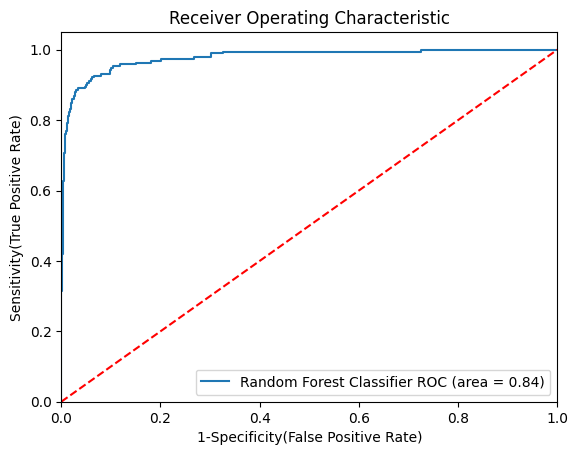

In [35]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

plt.figure()

auc_models = [
    {
    'label': 'Random Forest Classifier',
    'model' : RandomForestClassifier(max_depth=15, max_features=8, min_samples_split=2, n_estimators=1000),
    'auc':0.8397
}
]

for algo in auc_models:
    model = algo['model']
    model.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (algo['label'], algo['auc']))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("auc.png")
plt.show()
